In [1]:
%matplotlib inline

In [ ]:
# This notebook plots annual streamflow correlations to NAO and AO climate indices (Figure 3 in manuscript). 

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colorbar import ColorbarBase
from matplotlib.colors import Normalize
from pathlib import Path
import pandas as pds
from pandas import read_csv
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import Normalize
import os
sns.set()
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'

In [3]:
# Define functions used for plotting:
def plot_figs(basemap,glaciers,ax,iceland_shapefile_color,glaciers_color):
    # This function plots the basemap, the glaciers and sets x,ylimits and x,yticks
    # Set figure limits
    minx, miny = 222375, 307671
    maxx, maxy = 765246, 697520
    
    basemap.plot(ax=ax, color=iceland_shapefile_color,edgecolor='darkgray')
    glaciers.plot(ax=ax,facecolor=glaciers_color,edgecolor='none')
    ax.set_xlim(minx,maxx)
    ax.set_ylim(miny,maxy)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

def determine_extend(vmin,vmax,vmin_actual,vmax_actual):
    # Set 'extend' variable in accordance
    if vmin_actual < vmin and vmax_actual > vmax:
        extend = 'both'
    elif vmin_actual < vmin:
        extend = 'min'
    elif vmax_actual > vmax:
        extend = 'max'
    else:
        extend = 'neither'
    return(extend)

In [12]:
# Read the gauges shapefile that contains the indices and V numbers
gauges_gdf = gpd.read_file(Path(r"C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\D_gauges\3_shapefiles\gauges.shp"))
gauges_gdf = gauges_gdf.set_index('id')
gauges_gdf = gauges_gdf.set_crs('epsg:3057')
gauges = gauges_gdf.copy()

# Read the catchment characteristics - Extract area_calc and human influence
catchments_chara = pds.read_csv(Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\A_basins_total_upstrm\1_attributes\Catchment_attributes.csv'),sep=';')
catchments_chara = catchments_chara.set_index('id')
mask = catchments_chara['degimpact'] != 's'

# Read the catchment characteristics - Extract area_calc and human influence
hydro_sign = pds.read_csv(Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\lamah_ice\D_gauges\1_attributes\hydro_indices_1981_2018_unfiltered.csv'),sep=';')
hydro_sign = hydro_sign.set_index('id')

# Read catchments
catchments = gpd.read_file(Path(r"C:/Users/hordurbhe/Documents/Vinna/lamah/lamah_ice/lamah_ice/A_basins_total_upstrm/3_shapefiles/Basins_A.shp"))
catchments = catchments.set_index('id')
catchments = catchments.set_crs('epsg:3057')

bmap = gpd.read_file(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\stanford-xz811fy7881-shapefile\island_isn93.shp')
# Read glacier outlines
gpath = Path(r'C:\Users\hordurbhe\Documents\Vinna\lamah\lamah_ice\glacier_outline_1890_2019_hh_Aug2021\jökla-útlínur\2019_glacier_outlines.shp')
glaciers = gpd.read_file(gpath)
    
# Specify some plot attributes
iceland_shapefile_color = 'gray'
glaciers_color = 'white'
# Define plot specifications
colormap = 'RdBu'

shift_value = 100

In [34]:
# df_corr_ao_nao = pds.read_csv('climate_index_correlation_results.csv')
df_corr_ao_nao = pds.read_csv('climate_index_correlation_results_CI_not_normalized.csv')
df_corr_ao_nao = df_corr_ao_nao.set_index('Streamflow Gauge')
df_corr_ao_nao.index = [int(i) for i in df_corr_ao_nao.index]
df_corr_ao_nao = df_corr_ao_nao.sort_index()
df_corr_ao_nao = df_corr_ao_nao.drop(columns=['Unnamed: 0'])
merged_gdf = gauges_gdf.merge(df_corr_ao_nao, left_index=True, right_index=True)

start_year = 1950
end_year = 2024
maps_path = Path(r"C:\Users\hordurbhe\OneDrive - Landsvirkjun\Changes in streamflow in Iceland\paper\Figures_Final")

C:\Users\hordurbhe\AppData\Local\Temp\ipykernel_14620\2968931449.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


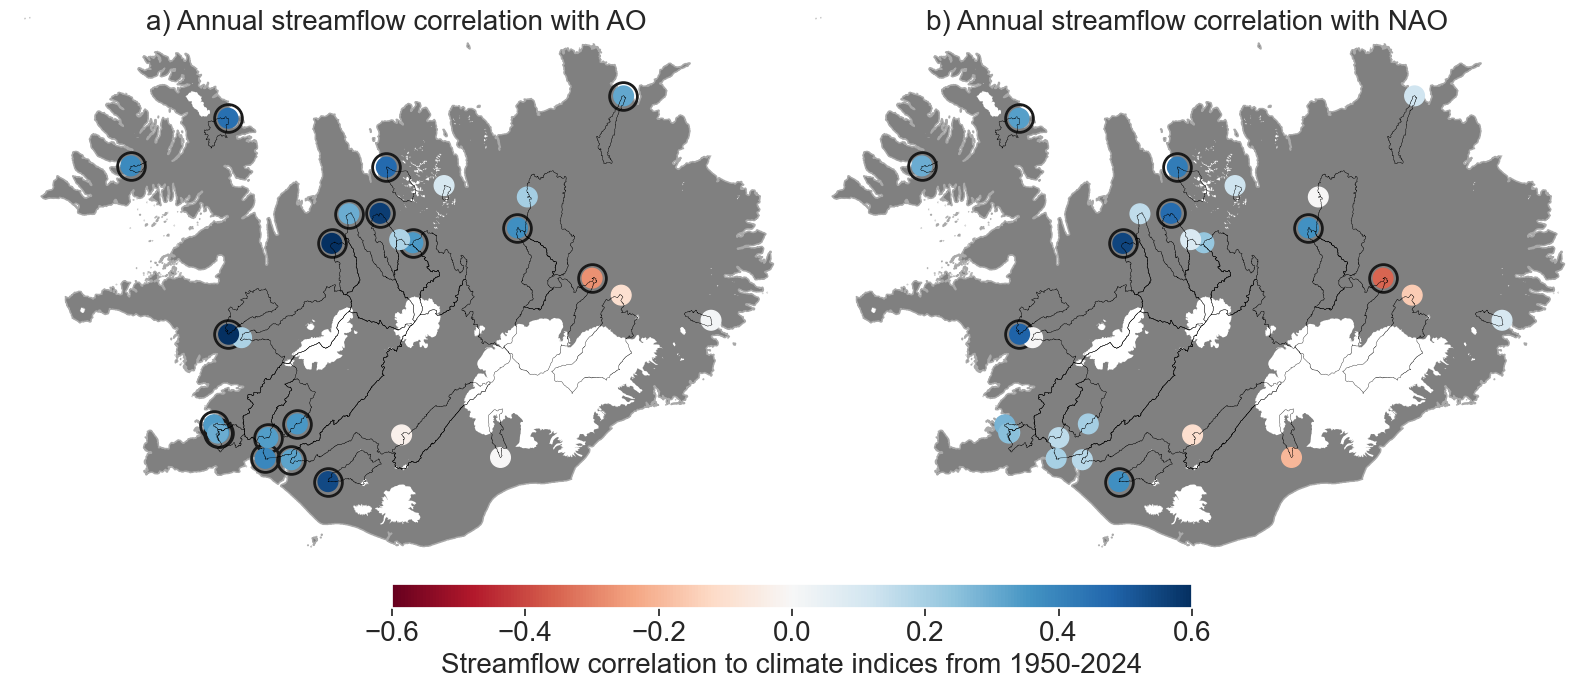

In [40]:
# Common settings for size and markers
global_marker_size = 200  # Marker size for points
global_marker_significant_size = 20  # Marker size for significant points
global_title_size = 20  # Title text size
global_label_size = 20  # Colorbar label size
global_tick_label_size = 20  # Tick label size
annual_vmin_climate_indices = -0.6
annual_vmax_climate_indices = 0.6

# Create a figure with two subplots (1x2 layout)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
# fig.patch.set_facecolor('lightgrey')

# Loop over the climate indices and plot on each subplot
for ax, climate_index in zip(axs, ['AO', 'NAO']):
    column = 'Correlation %s' % climate_index
    p_column = 'P-value %s' % climate_index
    
    # Calculate min and max for the color scale
    data_min = merged_gdf[column].min()
    data_max = merged_gdf[column].max()
    extend = determine_extend(annual_vmin_climate_indices, annual_vmax_climate_indices, data_min, data_max)

    # Plot the base map
    plot_figs(bmap, glaciers, ax, iceland_shapefile_color, glaciers_color)

    # Plot the data with adjusted marker sizes
    im = merged_gdf.plot(column=column, legend=False, vmin=annual_vmin_climate_indices, vmax=annual_vmax_climate_indices,
                         ax=ax, cmap=colormap, s=global_marker_size, zorder=2)

    # Plot significant points with larger markers
    significant_points = merged_gdf[merged_gdf[p_column] < 0.05]
    ax.plot(significant_points.geometry.x - shift_value, significant_points.geometry.y,
            marker='o', markersize=global_marker_significant_size, markeredgewidth=2,
            markerfacecolor='none', markeredgecolor='k', linestyle='none', lw=0.5, zorder=1)

    # Set map limits
    minx, miny = 222375, 307671
    maxx, maxy = 765246, 697520
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Set title for each subplot with larger font size
    if climate_index == 'AO':
        ax.set_title(f'a) Annual streamflow correlation with {climate_index}', size=global_title_size, y=0.95)
    else:
        ax.set_title(f'b) Annual streamflow correlation with {climate_index}', size=global_title_size, y=0.95)
    
    # Plot catchments
    catchments.loc[merged_gdf[column].dropna().index].plot(facecolor='none', edgecolor='black', ax=ax, zorder=3, lw=0.25)

# Create a common colorbar below the subplots
cax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  # Position for colorbar [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=colormap, norm=Normalize(vmin=annual_vmin_climate_indices, vmax=annual_vmax_climate_indices))
cb = ColorbarBase(cax, cmap=colormap, norm=Normalize(vmin=annual_vmin_climate_indices, vmax=annual_vmax_climate_indices), orientation='horizontal', extend=extend)

# Set colorbar label with larger font size
cb.set_label(f'Streamflow correlation to climate indices from {start_year}-{end_year}', size=global_label_size)
cb.ax.tick_params(labelsize=global_tick_label_size)  # Larger tick labels

# Adjust layout and save
plt.tight_layout()
# plt.tight_layout(rect=[0, 0.1, 1, 1])  # Leave space for colorbar at bottom
save_path = os.path.join(maps_path, 'Figure3_annual_correlation_AO_NAO.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
save_path = os.path.join(maps_path, 'Figure3_annual_correlation_AO_NAO.pdf')
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

In [39]:
# Print statistics
for climate_index in ['AO', 'NAO']:
    column = 'Correlation %s' % climate_index
    p_column = 'P-value %s' % climate_index
    
    # Filter out rows with NaN values in either correlation or p-value
    valid_data = merged_gdf[[column, p_column]].dropna()
    
    # Filter by significance
    significant_data = valid_data[valid_data[p_column] < 0.05]
    
    # Calculate statistics
    mean_val = valid_data[column].mean()
    count_val = valid_data[column].count()
    max_val = valid_data[column].max()
    min_val = valid_data[column].min()
    
    # Count significant positive and negative correlations
    significant_positive = significant_data[significant_data[column] > 0].shape[0]
    significant_negative = significant_data[significant_data[column] < 0].shape[0]
    
    # Print results
    print(f"Details for {climate_index}:")
    print(f"  Mean Correlation: {mean_val:.2f}")
    print(f"  Total Count: {count_val}")
    print(f"  Max Correlation: {max_val:.2f}")
    print(f"  Min Correlation: {min_val:.2f}")
    print(f"  Significant Positive Correlations (p < 0.05): {significant_positive}")
    print(f"  Significant Negative Correlations (p < 0.05): {significant_negative}")
    print()


Details for AO:
  Mean Correlation: 0.28
  Total Count: 27
  Max Correlation: 0.66
  Min Correlation: -0.28
  Significant Positive Correlations (p < 0.05): 18
  Significant Negative Correlations (p < 0.05): 1

Details for NAO:
  Mean Correlation: 0.18
  Total Count: 27
  Max Correlation: 0.55
  Min Correlation: -0.35
  Significant Positive Correlations (p < 0.05): 8
  Significant Negative Correlations (p < 0.05): 1

